# Simulated Data Preparation for Proteoform Grouping Benchmarks

This notebook describes the process of generating simulated data for proteoform grouping benchmarks. I will be crafting multiple scenarios, where a single and combined types of proteoforms are represented across various experimental setups. This is a very large and complex simulation problem and I cannot cover all possible scenarios. However, I will try to cover a few common changes that result in proteoforms with different properties. 

Types of events that result in proteoforms that I want to include here: 
1. **Isoforms**: Proteoforms that are the result of alternative splicing and or other events at transcription and translation. The simplest form since there are enough evidence to support the existence of these proteoforms and they are better documented across literature and in databases.
2. **Single Amino-acid PTMs**: Proteoforms that are the result of a single amino-acid, the sequence of peptide is not changed but the mass is different due to a presence of a PTM. There can be multiple PTMs on a single peptide, but for simplicity, I will only consider one PTM per peptide.
    - There are different types of PTMs that can change single peptide or can affect subsequent peptides. This will be reflected in the data.
3. **Proteolytic Cleavage**: Proteoforms that are the result of proteolytic cleavage events.
4. **Amino-acid change**: Any change in the amino-acid sequence of a peptide that results in a different peptide sequence, and will be registered as a different peptide, but will still be mapped to the same protein sequence. These will be hard to distinguish from miss-cleavages, so I will consider them as subsets of miss-cleavages.
        

The simulated data will use the following format:
- **Peptide**: A peptide sequence that is part of a protein as reported.
- **Protein**: A protein sequence that contains the peptide.
- 



In [1]:
import os
import sys
import feather
import warnings

import numpy as np # Numerical computing
import pandas as pd # Data manipulatio

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 

sys.path.append('../')
from src import utils, plots

warnings.filterwarnings('ignore')

# Initialize the timer
startTime = utils.getTime()

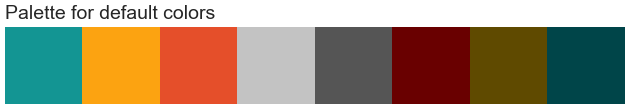

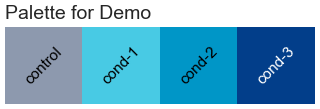

In [ ]:
# Create a dictionary for a greyscale color palette with 9 colors
def_colors = [
    "#139593", "#fca311", "#e54f2a",
    "#c3c3c3", "#555555",
    "#690000", "#5f4a00", "#004549"
]
demo_palette = {
    "control": "#8d99ae" ,
    "cond-1": "#48cae4" ,
    "cond-2": "#0096c7",
    "cond-3": "#023e8a",
}

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors, 
    save=False
)

plots.color_palette(
    demo_palette,
    name="Demo",
    save=False
)

In [ ]:
notebook_name = "demo"
data_path = "./data/input/"
output_path = f"./data/prepared/"
figure_path = f"./figures/{notebook_name}/"

# Create the output folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = figure_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

In [ ]:
# Parameters
n_proteins = 250
n_replicates = 5
conditions = ["control", "cond-1", "cond-2", "cond-3"]
shifts = {"control": 0, "cond-1": 1, "cond-2": 2, "cond-3": 3}  # Increasing differences
cond_filename_dict = {
    "control": [f"control_{i+1}" for i in range(n_replicates)],
    "cond-1": [f"cond-1_{i+1}" for i in range(n_replicates)],
    "cond-2": [f"cond-2_{i+1}" for i in range(n_replicates)],
    "cond-3": [f"cond-3_{i+1}" for i in range(n_replicates)],
}
cond_palette = {}
for condition, samples in cond_filename_dict.items():
    for sample in samples:
        cond_palette[sample] = demo_palette[condition]


# Generate protein IDs
protein_ids = [f"Protein_{i+1}" for i in range(n_proteins)]

# Function to generate base intensity values with more outliers closer to IQR
def generate_base_intensity():
    if np.random.rand() < 0.25:  # 30% chance to be an outlier
        return np.random.normal(loc=15, scale=4)  # Outliers closer to IQR
    else:
        return np.random.normal(loc=15, scale=2)  # Main distribution

# Generate data
data = []
for condition in conditions:
    for protein in protein_ids:
        base_intensity_log2 = generate_base_intensity() + shifts[condition]  # Apply shift
        for replicate in range(1, n_replicates + 1):
            replicate_intensity_log2 = base_intensity_log2 + np.random.normal(loc=0, scale=0.5)  # Smaller noise for replicates
            intensity = 2 ** replicate_intensity_log2  # Convert log2 intensity to linear scale
            data.append([protein, condition, replicate, intensity])

# Create DataFrame
df = pd.DataFrame(data, columns=["Protein", "Condition", "Replicate", "Intensity"])
df["Sample"] = df["Condition"] + "_" + df["Replicate"].astype(str)
df["log2_Intensity"] = np.log2(df["Intensity"])

# Display the first few rows of the DataFrame
print(df.head())

     Protein Condition  Replicate    Intensity     Sample  log2_Intensity
0  Protein_1   control          1 9240374.7954  control_1         23.1395
1  Protein_1   control          2 1817326.2092  control_2         20.7934
2  Protein_1   control          3 5580019.5188  control_3         22.4118
3  Protein_1   control          4 5317643.3193  control_4         22.3424
4  Protein_1   control          5 4566793.2348  control_5         22.1228


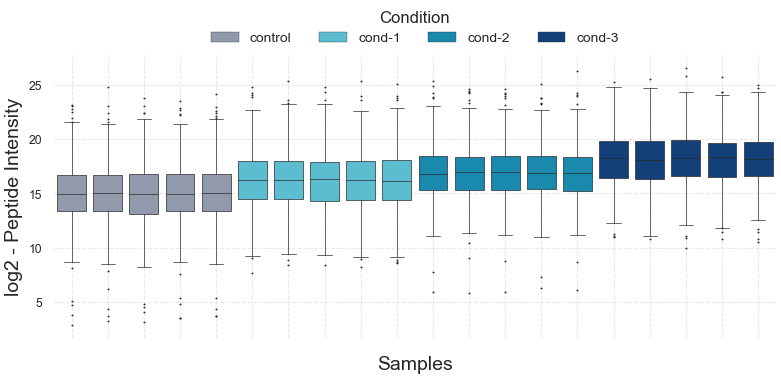

In [5]:
# Initialize the figure
fig, ax = plt.subplots(
    figsize=(8, 4)
)

# Create the boxplot
sns.boxplot(
    x="Sample",
    y="log2_Intensity",
    hue="Condition",
    data=df,
    ax=ax,
    dodge=False,
    palette=demo_palette,
    # showfliers=False
    fliersize=0.5,
    linewidth=0.5,
)
# Set the x-axis labels
ax.set_xlabel("Samples", fontsize=14)
ax.set_ylabel("log2 - Peptide Intensity", fontsize=14)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")
ax.set_xticklabels([])
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# place legend to upper right with 2 columns
ax.legend(
    ncol=4, frameon=False, title="Condition", 
    title_fontsize=12, fontsize=10, 
    # Center the legend on top
    bbox_to_anchor=(0.5, 1.1), loc="center"
)
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Demo_PeptideBoxplot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

In [6]:
log2_data = df.pivot_table(
    index="Protein",
    columns="Sample",
    values="log2_Intensity",
    aggfunc="mean"
)
log2_data

Sample,cond-1_1,cond-1_2,cond-1_3,cond-1_4,cond-1_5,cond-2_1,cond-2_2,cond-2_3,cond-2_4,cond-2_5,cond-3_1,cond-3_2,cond-3_3,cond-3_4,cond-3_5,control_1,control_2,control_3,control_4,control_5
Protein,,,,,,,,,,,,,,,,,,,,
Protein_1,16.6206,16.4961,16.8825,16.7005,16.9837,16.3697,16.1693,14.8658,15.1264,16.0561,20.3326,20.9125,20.1244,20.3104,20.4035,23.1395,20.7934,22.4118,22.3424,22.1228
Protein_10,20.4124,20.0705,19.6775,20.5058,20.3931,18.8458,17.8654,18.4602,18.7084,17.3352,17.7813,18.1536,18.7432,18.4421,17.3261,5.0966,6.1844,4.8675,5.3809,5.4054
Protein_100,24.0562,23.2539,23.2558,23.9772,23.9488,15.9739,16.1467,15.6968,15.1121,15.1496,20.8626,19.7594,21.2711,20.5827,20.6491,14.9419,14.7478,14.8059,15.0813,15.0331
Protein_101,15.9703,14.9143,15.4309,16.4588,16.1540,15.4723,15.0282,14.8566,15.6495,15.5301,17.9698,17.6519,17.2671,17.8603,17.7277,13.5281,13.1538,13.7808,14.3002,14.3739
Protein_102,16.2519,16.0263,16.1409,16.1253,15.0989,15.2653,16.3667,15.4864,14.2517,15.7963,20.2368,20.4263,20.8127,19.3056,21.4176,16.9652,17.6806,18.4317,17.8264,18.5218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Protein_95,18.5487,16.9961,18.4787,17.5676,17.9305,19.7243,19.1188,18.7674,18.3523,19.2815,23.0457,23.4483,23.9842,23.1719,22.9419,15.2832,15.7372,16.0662,16.1199,14.4234
Protein_96,14.6100,15.1330,14.2928,14.2207,13.2948,18.7819,19.2298,18.2761,18.7151,18.5365,24.7821,24.7288,25.8392,24.3512,24.3399,21.5621,22.4170,21.8199,21.1045,22.6315
Protein_97,14.6113,15.0013,15.3269,15.0819,14.7217,18.0919,18.1054,17.4910,18.2230,18.2229,18.8011,17.7630,18.3886,18.4908,18.5374,12.7815,12.3561,13.7706,12.0999,12.7889


In [7]:
centered_data = (log2_data - log2_data.mean()) / log2_data.std()
centered_data

Sample,cond-1_1,cond-1_2,cond-1_3,cond-1_4,cond-1_5,cond-2_1,cond-2_2,cond-2_3,cond-2_4,cond-2_5,cond-3_1,cond-3_2,cond-3_3,cond-3_4,cond-3_5,control_1,control_2,control_3,control_4,control_5
Protein,,,,,,,,,,,,,,,,,,,,
Protein_1,0.1532,0.1184,0.2614,0.1762,0.2688,-0.2065,-0.2684,-0.7633,-0.6741,-0.3064,0.8540,1.0668,0.7323,0.8568,0.8629,2.6405,1.9166,2.4074,2.3918,2.3231
Protein_10,1.5257,1.4091,1.2767,1.5540,1.4898,0.7183,0.3631,0.5754,0.7009,0.1772,-0.1425,0.0130,0.2151,0.1307,-0.3211,-3.1949,-2.8979,-3.2865,-3.1386,-3.1391
Protein_100,2.8446,2.5586,2.5766,2.8108,2.7633,-0.3543,-0.2768,-0.4538,-0.6796,-0.6490,1.0610,0.6264,1.1617,0.9626,0.9573,-0.0107,-0.0757,-0.0610,0.0243,0.0066
Protein_101,-0.0821,-0.4528,-0.2659,0.0887,-0.0284,-0.5417,-0.6933,-0.7667,-0.4733,-0.5052,-0.0689,-0.1786,-0.3377,-0.0954,-0.1666,-0.4680,-0.6010,-0.3937,-0.2304,-0.2088
Protein_102,0.0198,-0.0512,-0.0080,-0.0320,-0.4062,-0.6190,-0.1949,-0.5322,-1.0098,-0.4046,0.8165,0.8811,0.9901,0.4663,1.2530,0.6436,0.8908,1.1157,0.9194,1.1465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Protein_95,0.8511,0.2989,0.8412,0.4901,0.6079,1.0464,0.8299,0.6898,0.5642,0.9131,1.9136,2.0354,2.1777,1.9688,1.8394,0.0997,0.2503,0.3480,0.3629,-0.1926
Protein_96,-0.5745,-0.3738,-0.6793,-0.7216,-1.0524,0.6944,0.8712,0.5069,0.7035,0.6314,2.5918,2.5245,2.8723,2.4270,2.3773,2.1303,2.4517,2.2153,1.9882,2.4893
Protein_97,-0.5740,-0.4214,-0.3037,-0.4098,-0.5413,0.4367,0.4525,0.2145,0.5146,0.5129,0.2558,-0.1362,0.0823,0.1497,0.1449,-0.7095,-0.8639,-0.3970,-0.9478,-0.7267


In [8]:
# Adjusted data
# Calculate the mean of each peptide across the day1 samples
cntrPepMean = centered_data[cond_filename_dict["control"]].mean(axis=1)
# Substract cntrPepMean from each sample row-wise in centered_data
adjusted_dat = centered_data.subtract(cntrPepMean, axis=0)
adjusted_dat

Sample,cond-1_1,cond-1_2,cond-1_3,cond-1_4,cond-1_5,cond-2_1,cond-2_2,cond-2_3,cond-2_4,cond-2_5,cond-3_1,cond-3_2,cond-3_3,cond-3_4,cond-3_5,control_1,control_2,control_3,control_4,control_5
Protein,,,,,,,,,,,,,,,,,,,,
Protein_1,-2.1827,-2.2175,-2.0745,-2.1597,-2.0671,-2.5424,-2.6043,-3.0992,-3.0100,-2.6423,-1.4819,-1.2691,-1.6036,-1.4791,-1.4730,0.3046,-0.4193,0.0715,0.0559,-0.0128
Protein_10,4.6571,4.5405,4.4081,4.6854,4.6212,3.8497,3.4945,3.7068,3.8323,3.3086,2.9888,3.1444,3.3465,3.2621,2.8103,-0.0635,0.2335,-0.1551,-0.0072,-0.0078
Protein_100,2.8679,2.5819,2.5999,2.8342,2.7866,-0.3310,-0.2535,-0.4305,-0.6563,-0.6257,1.0843,0.6497,1.1850,0.9859,0.9807,0.0126,-0.0524,-0.0377,0.0476,0.0299
Protein_101,0.2982,-0.0724,0.1145,0.4691,0.3520,-0.1613,-0.3129,-0.3864,-0.0929,-0.1248,0.3115,0.2017,0.0427,0.2850,0.2138,-0.0876,-0.2207,-0.0133,0.1500,0.1716
Protein_102,-0.9234,-0.9944,-0.9512,-0.9752,-1.3494,-1.5622,-1.1381,-1.4754,-1.9530,-1.3478,-0.1267,-0.0621,0.0469,-0.4769,0.3098,-0.2996,-0.0524,0.1725,-0.0238,0.2033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Protein_95,0.6775,0.1253,0.6676,0.3165,0.4342,0.8727,0.6562,0.5162,0.3905,0.7394,1.7399,1.8617,2.0040,1.7951,1.6658,-0.0740,0.0767,0.1743,0.1893,-0.3663
Protein_96,-2.8295,-2.6288,-2.9343,-2.9766,-3.3073,-1.5605,-1.3838,-1.7481,-1.5515,-1.6235,0.3368,0.2695,0.6173,0.1721,0.1223,-0.1246,0.1967,-0.0397,-0.2668,0.2343
Protein_97,0.1549,0.3076,0.4253,0.3192,0.1877,1.1657,1.1815,0.9434,1.2435,1.2418,0.9847,0.5928,0.8113,0.8786,0.8739,0.0195,-0.1350,0.3319,-0.2188,0.0023


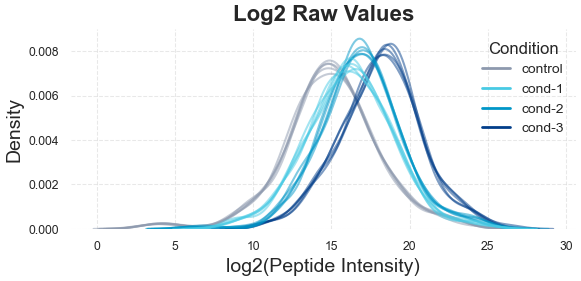

In [9]:
# Plot the log2 raw values with a density plot
# Initialize the figure and axis
fig, ax = plt.subplots(
    figsize=(6, 3)
)
sns.kdeplot(
    data = log2_data,
    ax=ax,
    # fill=True,
    palette=cond_palette,
    linewidth=1.5,
    alpha=0.5,
    legend=False,
)

ax.set_xlabel("log2(Peptide Intensity)", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.set_title("Log2 Raw Values", fontsize=16, fontweight="bold")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# Assemble the legend from status colors dictionary tumor and normal two
handles = []
labels = []
for k, v in demo_palette.items():
    handles.append(plt.Line2D([0], [0], color=v, lw=2))
    labels.append(k)

ax.legend(
    handles,
    labels,
    title="Condition",
    title_fontsize=12,
    fontsize=10,
    frameon=False,
    loc="upper right",
)
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Demo_Log2DensityPlot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

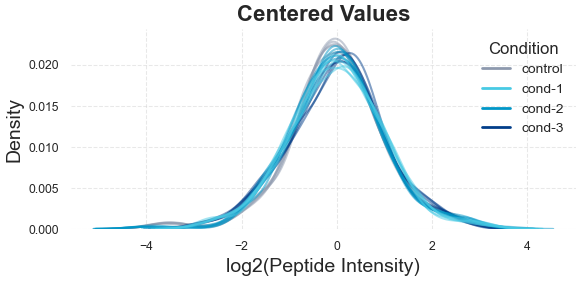

In [10]:
# Plot the log2 centered values with a density plot
# Initialize the figure and axis
fig, ax = plt.subplots(
    figsize=(6, 3)
)

sns.kdeplot(
    data=centered_data,
    ax=ax,
    # fill=True,
    palette=cond_palette,
    linewidth=1.5,
    alpha=0.5,
    legend=False,
)

ax.set_xlabel("log2(Peptide Intensity)", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.set_title("Centered Values", fontsize=16, fontweight="bold")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# Assemble the legend from status colors dictionary tumor and normal two
handles = []
labels = []
for k, v in demo_palette.items():
    handles.append(plt.Line2D([0], [0], color=v, lw=2))
    labels.append(k)

ax.legend(
    handles,
    labels,
    title="Condition",
    title_fontsize=12,
    fontsize=10,
    frameon=False,
    loc="upper right",
)
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Demo_CenteredDensityPlot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

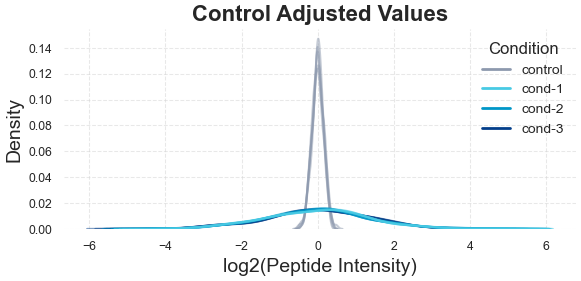

In [11]:
# Plot the log2 adjusted values with a density plot
# Initialize the figure and axis
fig, ax = plt.subplots(
    figsize=(6, 3)
)

sns.kdeplot(
    data=adjusted_dat,
    ax=ax,
    # fill=True,
    palette=cond_palette,
    linewidth=1.5,
    alpha=0.5,
    legend=False,
)

ax.set_xlabel("log2(Peptide Intensity)", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.set_title("Control Adjusted Values", fontsize=16, fontweight="bold")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# Assemble the legend from status colors dictionary tumor and normal two
handles = []
labels = []
for k, v in demo_palette.items():
    handles.append(plt.Line2D([0], [0], color=v, lw=2))
    labels.append(k)

ax.legend(
    handles,
    labels,
    title="Condition",
    title_fontsize=12,
    fontsize=10,
    frameon=False,
    loc="upper right",
)
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Demo_AdjustedDensityPlot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi, 
    transparent=transparet_bg
)

In [12]:
adjusted_dat.loc[[
    'Protein_1', 'Protein_2', 'Protein_3', 'Protein_4', 'Protein_5', 'Protein_6', 'Protein_7', 'Protein_8', 'Protein_9', 'Protein_10'
]].to_csv(
    output_path + "demo_data.csv"
)

## Example 1

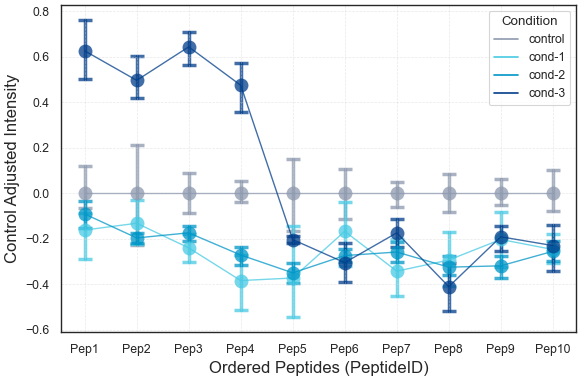

In [13]:
nPeps = 10
nReps = 5

# Generate for control mean is 0 and std is 0.25
control_data = np.random.normal(loc=0, scale=0.15, size=(nPeps, nReps))
control_data
# Move the mean to 1 and std to 0.5
cond1_data = np.random.normal(loc=-0.25, scale=0.15, size=(nPeps, nReps))
cond1_data
# Move the mean to 2 and std to 0.75
cond2_data = np.random.normal(loc=-0.27, scale=0.05, size=(nPeps, nReps))
cond2_data
# Move the mean to 3 and std to 1
cond3_data = np.random.normal(loc=-0.23, scale=0.1, size=(nPeps, nReps))
cond3_data

# put all the data together in a DataFrame
data = np.concatenate([control_data, cond1_data, cond2_data, cond3_data], axis=1)
data = pd.DataFrame(
    data,
    index=[f"Pep{i+1}" for i in range(nPeps)],
    columns=[
        "control_1", "control_2", "control_3", "control_4", "control_5",
        "cond-1_1", "cond-1_2", "cond-1_3", "cond-1_4", "cond-1_5",
        "cond-2_1", "cond-2_2", "cond-2_3", "cond-2_4", "cond-2_5",
        "cond-3_1", "cond-3_2", "cond-3_3", "cond-3_4", "cond-3_5"
    ]
)
# Adjust the data by control mean
data = data - data.loc[:, "control_1":"control_5"].mean(axis=1).values[:, None]

data = data.reset_index().melt(
    id_vars="index",
    var_name="Sample",
    value_name="Intensity"
)
data["Condition"] = data["Sample"].str.split("_", expand=True)[0]
# Introduce peptide moves
# data.loc[
#     ((data["Condition"] == "cond-1") & (data["index"].isin(["Pep1", "Pep2"]))), "Intensity"] += .5
# data.loc[
#     ((data["Condition"] == "cond-2") & (data["index"].isin(["Pep2", "Pep3"]))), "Intensity"] -= .75
data.loc[
    ((data["Condition"] == "cond-3") & (data["index"].isin(["Pep1", "Pep2", "Pep3", "Pep4"]))), "Intensity"] += .75

# Initialize the figure
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    ax=ax,
    data=data,
    x="index",
    y="Intensity",
    hue="Condition",
    palette=demo_palette,
    rasterized=True,
    # Add styling
    alpha=0.75,

    ## Markers
    marker="o",
    markersize=10,
    markeredgewidth=0,
    # markeredgecolor="black",
    ## Line style
    linewidth=1,
    linestyle="-",
    dashes=False,
    # errorbar
    err_style="bars",
    err_kws={"capsize": 5, "elinewidth": 2.5, "capthick": 2.5, "zorder": 0, "linewidth": 1.5},
)
ax.set_xlabel(f"Ordered Peptides (PeptideID)", fontsize=12)
ax.set_ylabel("Control Adjusted Intensity", fontsize=12)
ax.set_title(
    "",
    fontsize=16,
    fontweight="bold",
)
ax.grid("both", linestyle="--", linewidth=0.5, alpha=0.5, color="lightgrey")
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Demo_Example1_PeptideConditionLineplot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi, 
    transparent=transparet_bg
)

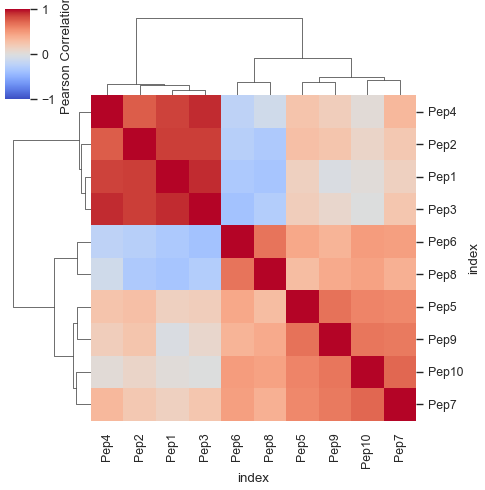

In [14]:
corr_df = data.pivot_table(
    index="index",
    columns="Sample",
    values="Intensity",
    aggfunc="mean"
).T.corr(method="pearson")

sns.clustermap(
    corr_df,
    figsize=(5, 5),
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    row_cluster=True,
    col_cluster=True,
    method="complete",
    metric="euclidean",
    cbar_kws={"label": "Pearson Correlation",},
    rasterized=True,
)

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Demo_Example1_PeptideConditionCorrelation",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

# Example 2

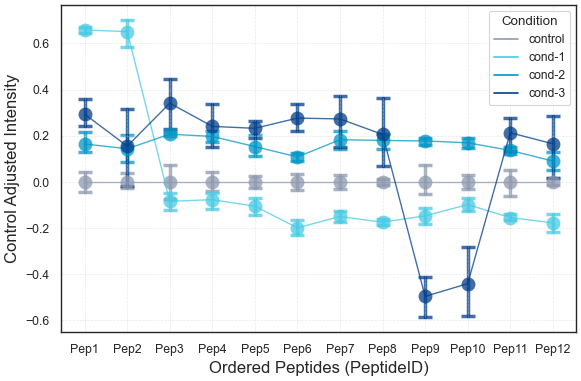

In [15]:
nPeps = 12
nReps = 5

# Generate for control mean is 0 and std is 0.25
control_data = np.random.normal(loc=0, scale=0.05, size=(nPeps, nReps))
control_data
# Move the mean to 1 and std to 0.5
cond1_data = np.random.normal(loc=-0.15, scale=0.05, size=(nPeps, nReps))
cond1_data
# Move the mean to 2 and std to 0.75
cond2_data = np.random.normal(loc=0.15, scale=0.05, size=(nPeps, nReps))
cond2_data
# Move the mean to 3 and std to 1
cond3_data = np.random.normal(loc=0.25, scale=0.14, size=(nPeps, nReps))
cond3_data

# put all the data together in a DataFrame
data = np.concatenate([control_data, cond1_data, cond2_data, cond3_data], axis=1)
data = pd.DataFrame(
    data,
    index=[f"Pep{i+1}" for i in range(nPeps)],
    columns=[
        "control_1", "control_2", "control_3", "control_4", "control_5",
        "cond-1_1", "cond-1_2", "cond-1_3", "cond-1_4", "cond-1_5",
        "cond-2_1", "cond-2_2", "cond-2_3", "cond-2_4", "cond-2_5",
        "cond-3_1", "cond-3_2", "cond-3_3", "cond-3_4", "cond-3_5"
    ]
)
# Adjust the data by control mean
data = data - data.loc[:, "control_1":"control_5"].mean(axis=1).values[:, None]

data = data.reset_index().melt(
    id_vars="index",
    var_name="Sample",
    value_name="Intensity"
)
data["Condition"] = data["Sample"].str.split("_", expand=True)[0]
# Introduce peptide moves
data.loc[
    ((data["Condition"] == "cond-1") & (data["index"].isin(["Pep1", "Pep2"]))), "Intensity"] += .75
# data.loc[
#     ((data["Condition"] == "cond-2") & (data["index"].isin(["Pep2", "Pep3"]))), "Intensity"] -= .75
data.loc[
    ((data["Condition"] == "cond-3") & (data["index"].isin(["Pep9", "Pep10"]))), "Intensity"] -= .75

# Initialize the figure
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    ax=ax,
    data=data,
    x="index",
    y="Intensity",
    hue="Condition",
    palette=demo_palette,
    rasterized=True,
    # Add styling
    alpha=0.75,

    ## Markers
    marker="o",
    markersize=10,
    markeredgewidth=0,
    # markeredgecolor="black",
    ## Line style
    linewidth=1,
    linestyle="-",
    dashes=False,
    # errorbar
    err_style="bars",
    err_kws={"capsize": 5, "elinewidth": 2.5, "capthick": 2.5, "zorder": 0, "linewidth": 1.5},
)
ax.set_xlabel(f"Ordered Peptides (PeptideID)", fontsize=12)
ax.set_ylabel("Control Adjusted Intensity", fontsize=12)
ax.set_title(
    "",
    fontsize=16,
    fontweight="bold",
)
ax.grid("both", linestyle="--", linewidth=0.5, alpha=0.5, color="lightgrey")
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Demo_Example2_PeptideConditionLineplot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi, 
    transparent=transparet_bg
)

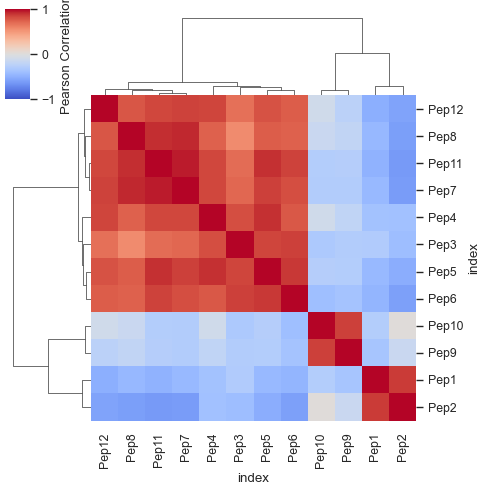

In [16]:
corr_df = data.pivot_table(
    index="index",
    columns="Sample",
    values="Intensity",
    aggfunc="mean"
).T.corr(method="pearson")

sns.clustermap(
    corr_df,
    figsize=(5, 5),
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    row_cluster=True,
    col_cluster=True,
    method="complete",
    metric="euclidean",
    cbar_kws={"label": "Pearson Correlation",},
    rasterized=True,
)

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Demo_Example2_PeptideConditionCorrelation",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Example 3

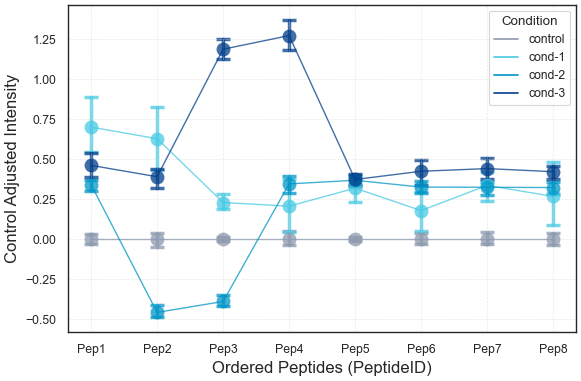

In [17]:
nPeps = 8
nReps = 5

# Generate for control mean is 0 and std is 0.25
control_data = np.random.normal(loc=0, scale=0.05, size=(nPeps, nReps))
control_data
# Move the mean to 1 and std to 0.5
cond1_data = np.random.normal(loc=0.25, scale=0.15, size=(nPeps, nReps))
cond1_data
# Move the mean to 2 and std to 0.75
cond2_data = np.random.normal(loc=0.35, scale=0.05, size=(nPeps, nReps))
cond2_data
# Move the mean to 3 and std to 1
cond3_data = np.random.normal(loc=0.45, scale=0.1, size=(nPeps, nReps))
cond3_data

# put all the data together in a DataFrame
data = np.concatenate([control_data, cond1_data, cond2_data, cond3_data], axis=1)
data = pd.DataFrame(
    data,
    index=[f"Pep{i+1}" for i in range(nPeps)],
    columns=[
        "control_1", "control_2", "control_3", "control_4", "control_5",
        "cond-1_1", "cond-1_2", "cond-1_3", "cond-1_4", "cond-1_5",
        "cond-2_1", "cond-2_2", "cond-2_3", "cond-2_4", "cond-2_5",
        "cond-3_1", "cond-3_2", "cond-3_3", "cond-3_4", "cond-3_5"
    ]
)
# Adjust the data by control mean
data = data - data.loc[:, "control_1":"control_5"].mean(axis=1).values[:, None]

data = data.reset_index().melt(
    id_vars="index",
    var_name="Sample",
    value_name="Intensity"
)
data["Condition"] = data["Sample"].str.split("_", expand=True)[0]
# Introduce peptide moves
data.loc[
    ((data["Condition"] == "cond-1") & (data["index"].isin(["Pep1", "Pep2"]))), "Intensity"] += .5
data.loc[
    ((data["Condition"] == "cond-2") & (data["index"].isin(["Pep2", "Pep3"]))), "Intensity"] -= .75
data.loc[
    ((data["Condition"] == "cond-3") & (data["index"].isin(["Pep3", "Pep4"]))), "Intensity"] += .75

# Initialize the figure
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    ax=ax,
    data=data,
    x="index",
    y="Intensity",
    hue="Condition",
    palette=demo_palette,
    rasterized=True,
    # Add styling
    alpha=0.75,

    ## Markers
    marker="o",
    markersize=10,
    markeredgewidth=0,
    # markeredgecolor="black",
    ## Line style
    linewidth=1,
    linestyle="-",
    dashes=False,
    # errorbar
    err_style="bars",
    err_kws={"capsize": 5, "elinewidth": 2.5, "capthick": 2.5, "zorder": 0, "linewidth": 1.5},
)
ax.set_xlabel(f"Ordered Peptides (PeptideID)", fontsize=12)
ax.set_ylabel("Control Adjusted Intensity", fontsize=12)
ax.set_title(
    "",
    fontsize=16,
    fontweight="bold",
)
ax.grid("both", linestyle="--", linewidth=0.5, alpha=0.5, color="lightgrey")
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Demo_Example3_PeptideConditionLineplot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi, 
    transparent=transparet_bg
)

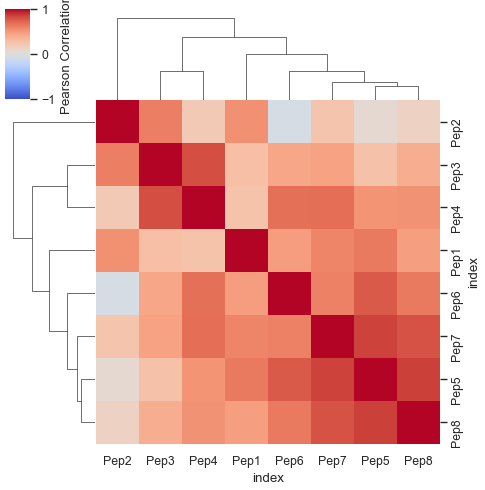

In [18]:
corr_df = data.pivot_table(
    index="index",
    columns="Sample",
    values="Intensity",
    aggfunc="mean"
).T.corr(method="pearson")

sns.clustermap(
    corr_df,
    figsize=(5, 5),
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    row_cluster=True,
    col_cluster=True,
    method="complete",
    metric="euclidean",
    cbar_kws={"label": "Pearson Correlation",},
    rasterized=True,
)

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Demo_Example3_PeptideConditionCorrelation",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)